# Data Analysis

[View this notebook in nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2023/AITA-Blame-Analysis/blob/main/code/data_analysis.ipynb)

## Table of Contents

1. [Set Up](#Set-Up)
2. [How much context and justification do the posters give?](#Question:-How-much-context-and-justification-do-the-posters-give?)
    1. [Finding Token Count of Each Post](#Finding-Token-Count-of-Each-Post)
    2. [Finding Token Count of Post Titles](#Finding-Token-Count-of-Post-Titles)
3. [Who do their stories focalize?](#Question:-Who-do-their-stories-focalize?)
    1. [Setting Up SpaCy](#Setting-up-spaCy)
    2.[Finding Top Subjects per Ruling](#Finding-Top-Subjects-per-Ruling)
4. [How much agency do the writers express](#Question:-How-much-agency-do-the-writers-express?)
    1. [Separating Passive and Active Nominal Subjects](#Separating-Passive-and-Active-Nominal-Subjects)
    2. [Example, Post with the Overall Most Passive Subjects](#Example,-Post-with-the-Overall-Most-Passive-Subjects)
    3. [Example, Post with the Highest Passive to Active Subject Ratio](#Example,-Post-with-the-Highest-Passive-to-Active-Subject-Ratio*)
    4. [Calculating Passive Subjects Across Rulings](#Calculating-Passive-Subjects-Across-Rulings)
    5. [Breakdown of NTA Subjects](#Breakdown-of-NTA-Subjects)
    6. [Example, "Everything" as a Reflection on Circumstance](#Example,-"Everything"-as-a-Reflection-on-Circumstance)
    7. [Breakdown of YTA Subjects](#Breakdown-of-YTA-Subjects)
    8. [Example, Syntactic Feasibility of "Them" as a Subject?](#Example,-Syntactic-Feasibility-of-"Them"-as-a-Subject?)
    9. [Example, "Kid" as Unempowered in Narrative](#Example,-"Kid"-as-Unempowered-in-Narrative)
    10. [Gendering of Active Versus Passive Subjects](#Gendering-of-Active-Versus-Passive-Subjects)
5. [Conclusions](#Conclusions)

## Set Up

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from scipy import stats

In [2]:
analysis_df = pd.read_csv('../data/aita_data.csv')

To prevent clutter and to maintain a clean version of the DataFrame in case I need to revert, I will be saving any analysis and edits to the original DataFrame to a copy of the corpus. If something might be useful in the future, I will add that column to analysis_df. But, if it's likely bound to the analysis only in one section, I will make another DataFrame for that aside.

Checking to see if it populated properly:

In [3]:
analysis_df.head()

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio
0,0,1,AITA for sleeping during the day?,"I honestly thought what I was doing was fine, ...",Not the A-hole,34,7,0.82
1,2,0,AITAH for refusing to change out of my semi-se...,My boyfriend was FaceTiming his cousin and his...,Not the A-hole,23,8,0.78
2,6,2,AITA for not helping my neighbor?,I (M26) live in a large apartment complex with...,Not the A-hole,253,1016,0.97
3,9,3,AITA for threatening to lock my housemate's wi...,I'll keep it short; my housemate moved in arou...,Everyone Sucks,34,4,0.76
4,25,4,AITA for allowing my bio dad and his wife to b...,I found out that I am pregnant about 5 1/2 mon...,Not the A-hole,62,46,0.88


In [4]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9414 entries, 0 to 9413
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9414 non-null   int64  
 1   AuthorID      9414 non-null   int64  
 2   Title         9414 non-null   object 
 3   Text          9414 non-null   object 
 4   Ruling        9414 non-null   object 
 5   CommentCount  9414 non-null   int64  
 6   Score         9414 non-null   int64  
 7   UpvoteRatio   9414 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 588.5+ KB


Let's look at the breakdown of rulings:

In [5]:
analysis_df.Ruling.value_counts()

Not the A-hole     7180
Asshole            1399
No A-holes here     471
Everyone Sucks      364
Name: Ruling, dtype: int64

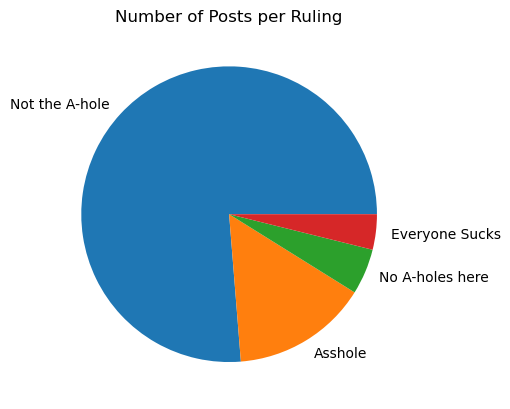

In [6]:
rulings_graph = plt.pie(analysis_df.Ruling.value_counts(), labels=["Not the A-hole", "Asshole", "No A-holes here", "Everyone Sucks"])
plt.title("Number of Posts per Ruling")
plt.savefig('../figures/posts_breakdown.png')
plt.show()

A vast majority of rulings believe that the poster is not the asshole. There's significantly less data for all the other rulings, but especially No Assholes here and Everyone Sucks Here. This makes sense, as the premise of the subreddit emphasizes the binary of were you good or bad in a situation, so the two more nuanced rulings have less usage.

## Question: How much context and justification do the posters give?

### _Practically: How does post length vary between rulings?_

Based on the subreddit's [Rules](https://www.reddit.com/r/AmItheAsshole/about/rules/), posts are limited to 3000 characters. However, not every story needs to take up that entire length to be told. Is there any meaningful variance between the overall post lengths of the four rulings? I could imagine that people trying to shake the blame off themselves would spend more time trying to justify their actions.

### Finding Token Count of Each Post

In [7]:
analysis_df["Tokens"] = analysis_df.Text.map(nltk.word_tokenize)
analysis_df["TokenCount"] = analysis_df.Tokens.map(lambda x: len(x))
analysis_df["Sentences"] = analysis_df.Text.map(nltk.sent_tokenize)

In [8]:
tokencount_compare = analysis_df.groupby("Ruling")["TokenCount"].mean()
tokencount_compare = tokencount_compare.to_frame()
print(tokencount_compare)

                 TokenCount
Ruling                     
Asshole          421.760543
Everyone Sucks   478.607143
No A-holes here  383.898089
Not the A-hole   445.821866


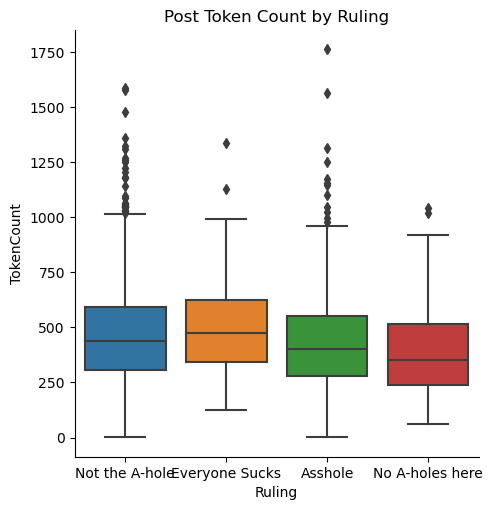

In [9]:
sns.catplot(x="Ruling", y="TokenCount", data=analysis_df, kind="box")
plt.title("Post Token Count by Ruling")
plt.savefig('../figures/post_token_count.png')
plt.show()

This data shows that writers declared as Not the Asshole actually write the most on average. Perhaps this could imply that, instead of being perceived as trying to over-justify their actions, writing more simply provides a higher amount of context that allows readers to actually understand their position. Conversely, perhaps the low token count on No Assholes Here shows that there's not enough of a story being told to justify a ruling. Or, that a situation in itself is so small that you shouldn't even have to worry about it.

Writers declared as Assholes seem to have the widest variance in how long each post is. This might suggest what I came into this test hypothesizing: that readers would be able to detect someone who is trying to overcompensate for their actions. This might also be attributed to a variety of other causes, though. Maybe some situations just need much more context to explain thoroughly.

In [10]:
yta = analysis_df[(analysis_df.Ruling == "Asshole")].TokenCount
nta = analysis_df[(analysis_df.Ruling == "Not the A-hole")].TokenCount
nah = analysis_df[(analysis_df.Ruling == "No A-holes here")].TokenCount
esh = analysis_df[(analysis_df.Ruling == "Everyone Sucks")].TokenCount

stats.f_oneway(yta, nta, nah, esh)

F_onewayResult(statistic=28.19592519133767, pvalue=3.826423806329736e-18)

The one-way ANOVA shows there is some meaningful distinction between the groups.

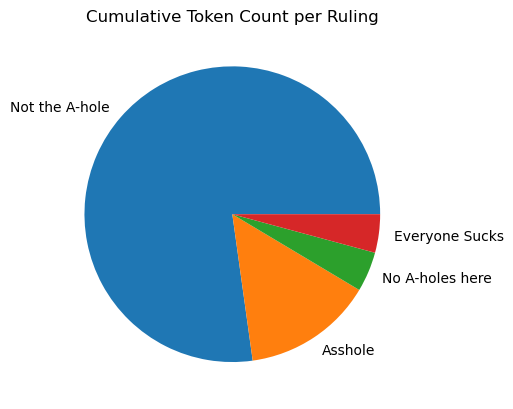

In [11]:
yta = np.sum(analysis_df[(analysis_df.Ruling == "Asshole")].TokenCount)
nta = np.sum(analysis_df[(analysis_df.Ruling == "Not the A-hole")].TokenCount)
nah = np.sum(analysis_df[(analysis_df.Ruling == "No A-holes here")].TokenCount)
esh = np.sum(analysis_df[(analysis_df.Ruling == "Everyone Sucks")].TokenCount)
rulings_graph = plt.pie([nta, yta, nah, esh], labels=["Not the A-hole", "Asshole", "No A-holes here", "Everyone Sucks"])
plt.title("Cumulative Token Count per Ruling")
plt.savefig('../figures/tokens_breakdown.png')
plt.show()

Here is another pie chart like the one prior which represents the number of tokens per ruling in the data set.

### Finding Token Count of Post Titles

I'll also consider the length of the post title, as that's the first first impression people will have on the subject.

In [12]:
analysis_df["TitleTokens"] = analysis_df.Title.map(nltk.word_tokenize)
analysis_df["TitleTkCount"] = analysis_df.TitleTokens.map(lambda x: len(x))

In [13]:
tokencount_compare = analysis_df.groupby("Ruling")["TitleTkCount"].mean()
tokencount_compare = tokencount_compare.to_frame()
print(tokencount_compare)

                 TitleTkCount
Ruling                       
Asshole             13.383846
Everyone Sucks      12.618132
No A-holes here     12.600849
Not the A-hole      12.881894


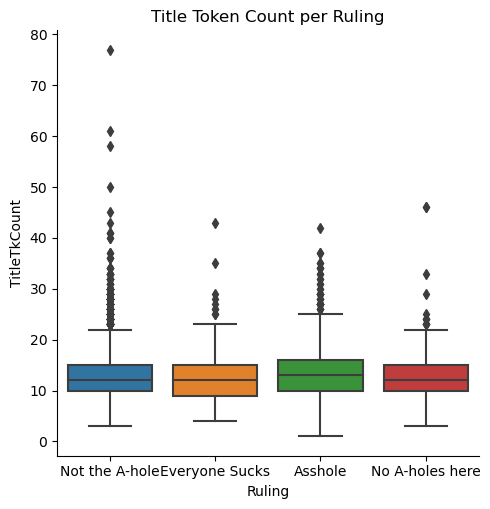

In [14]:
sns.catplot(x="Ruling", y="TitleTkCount", data=analysis_df, kind="box")
plt.title("Title Token Count per Ruling")
plt.savefig('../figures/title_token_count.png')
plt.show()

It makes sense that the differences between them are so minimal, since there's a strict limit of 300 characters on any Reddit post title. Visually, is also seems that there's so much variance in how many words are used that it's not very meaningful to analyze.

In [15]:
yta = analysis_df[analysis_df.Ruling == "Asshole"].TitleTkCount
nta = analysis_df[analysis_df.Ruling == "Not the A-hole"].TitleTkCount
nah = analysis_df[analysis_df.Ruling == "No A-holes here"].TitleTkCount
esh = analysis_df[analysis_df.Ruling == "Everyone Sucks"].TitleTkCount

stats.f_oneway(yta, nta, nah, esh)

F_onewayResult(statistic=5.399421283656125, pvalue=0.0010390264201330663)

The one-way ANOVA here shows that not only is there not much meaningful distinction between the groups, and also there's a lot of in-group variance (as seen in the box plot).

## Question: Who do their stories focalize?

### _Practically: Do the most common subjects of sentences vary between rulings?_

Now I'm going to analyze what the common sentence subjects are within each post. Out of context, I anticipate that this may not provide the deepest look into the writing practices of each user, but I'm hoping this will set me up for some deeper analysis in later sections. This also seems like a reasonable task to start using [spaCy](https://spacy.io/) for the first time. SpaCy allows me to break each sentence down into tokens, and retrieve information like each token's part of speech and its dependencies. This allows me to isolate the noun head of each subject.

### Setting Up SpaCy

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
analysis_df["SpacyText"] = analysis_df["Text"].apply(lambda x: nlp(x.lower()))

Before I do anything else I'm going to save so I don't have to run the Spacy pipeline on the data ever again. This took so long to process...

There's some complications trying to save this all as one pickled DataFrame, so I'm just going to pull out the Docs generated by spaCy and rejoin them with the DataFrame whenever I need it.

In [18]:
import pickle

In [19]:
with open("../data/aita_internal_spacytext.pkl", "wb") as f:
    pickle.dump(analysis_df["SpacyText"], f)

Quick check to see if that worked:

In [20]:
with open("../data/aita_internal_spacytext.pkl", "rb") as f:
    pkl_test = pickle.load(f)

for sent in pkl_test.iloc[0].sents:
    for tok in sent:
        print(tok.dep_, end=', ')

nsubj, advmod, ROOT, dobj, nsubj, aux, csubj, ccomp, acomp, punct, cc, poss, nsubj, aux, aux, conj, prep, pobj, det, npadvmod, advmod, mark, nsubj, advcl, aux, xcomp, det, dobj, punct, nsubj, ccomp, prep, poss, pobj, punct, nsubj, ROOT, prep, pobj, prep, det, amod, pobj, punct, cc, mark, nsubj, advcl, amod, dobj, prep, poss, pobj, punct, nsubj, conj, aux, xcomp, dobj, prep, pobj, advmod, prep, det, pobj, cc, conj, pobj, mark, det, nsubj, nsubj, relcl, prep, aux, neg, advcl, prt, prep, pcomp, nummod, cc, conj, pobj, punct, cc, nsubj, conj, advmod, advmod, prep, det, pobj, punct, nsubj, ROOT, poss, dobj, cc, conj, preconj, advmod, advmod, prep, det, pobj, prep, pobj, punct, advmod, prep, det, pobj, punct, cc, advmod, conj, pobj, punct, dep, poss, nsubj, aux, aux, ROOT, cc, conj, dobj, oprd, prep, pcomp, det, npadvmod, prep, pobj, punct, advmod, punct, nsubj, ccomp, advmod, acomp, prep, pobj, prep, poss, pobj, cc, conj, advmod, punct, cc, mark, nsubj, advcl, advmod, acomp, nsubj, advmod, 

Looks good!

Moving on to the actual subjects. I will collect all subjects, which spaCy tags with one of two labels. "nsubj" is for active nominal subjects and "nsubjpass" is for passive nominal subjects.

In [21]:
# For every sentence, go through each token and find if it is a nominal subject. If it's a nominal subject, save it.
analysis_df["Subjects"] = analysis_df["SpacyText"].apply(lambda x: [[tok for tok in sent if (tok.dep_ == "nsubj" or tok.dep_ == "nsubjpass")] for sent in x.sents])
analysis_df["Subjects"] = analysis_df.Subjects.map(lambda x: sum(x, [])) # This is an array of arrays, I want to unpack into just 1 array

analysis_df.head(10)

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio,Tokens,TokenCount,Sentences,TitleTokens,TitleTkCount,SpacyText,Subjects
0,0,1,AITA for sleeping during the day?,"I honestly thought what I was doing was fine, ...",Not the A-hole,34,7,0.82,"[I, honestly, thought, what, I, was, doing, wa...",204,"[I honestly thought what I was doing was fine,...","[AITA, for, sleeping, during, the, day, ?]",7,"(i, honestly, thought, what, i, was, doing, wa...","[i, i, dad, i, i, i, i, i, editors, i, they, i..."
1,2,0,AITAH for refusing to change out of my semi-se...,My boyfriend was FaceTiming his cousin and his...,Not the A-hole,23,8,0.78,"[My, boyfriend, was, FaceTiming, his, cousin, ...",339,[My boyfriend was FaceTiming his cousin and hi...,"[AITAH, for, refusing, to, change, out, of, my...",13,"(my, boyfriend, was, facetiming, his, cousin, ...","[boyfriend, they, i, i, i, it, i, i, he, you, ..."
2,6,2,AITA for not helping my neighbor?,I (M26) live in a large apartment complex with...,Not the A-hole,253,1016,0.97,"[I, (, M26, ), live, in, a, large, apartment, ...",570,[I (M26) live in a large apartment complex wit...,"[AITA, for, not, helping, my, neighbor, ?]",7,"(i, (, m26, ), live, in, a, large, apartment, ...","[i, i, which, it, i, i, units, that, i, guy, d..."
3,9,3,AITA for threatening to lock my housemate's wi...,I'll keep it short; my housemate moved in arou...,Everyone Sucks,34,4,0.76,"[I, 'll, keep, it, short, ;, my, housemate, mo...",390,[I'll keep it short; my housemate moved in aro...,"[AITA, for, threatening, to, lock, my, housema...",15,"(i, 'll, keep, it, short, ;, my, housemate, mo...","[i, housemate, he, that, i, he, he, i, he, tha..."
4,25,4,AITA for allowing my bio dad and his wife to b...,I found out that I am pregnant about 5 1/2 mon...,Not the A-hole,62,46,0.88,"[I, found, out, that, I, am, pregnant, about, ...",408,[I found out that I am pregnant about 5 1/2 mo...,"[AITA, for, allowing, my, bio, dad, and, his, ...",16,"(i, found, out, that, i, am, pregnant, about, ...","[i, i, i, i, mom, she, she, i, who, some, i, i..."
5,29,5,WIBTA for confronting my dad about skipping Ch...,My (31F) parents (55F) and (63M) have been sep...,Not the A-hole,20,3,0.81,"[My, (, 31F, ), parents, (, 55F, ), and, (, 63...",583,[My (31F) parents (55F) and (63M) have been se...,"[WIBTA, for, confronting, my, dad, about, skip...",8,"(my, (, 31f, ), parents, (, 55f, ), and, (, 63...","[parents, i, they, it, i, i, i, husband, that,..."
6,39,6,WIBTA if on a day trip with friends I opt out ...,I (26F) live in the US and my friend from anot...,Not the A-hole,10,8,1.00,"[I, (, 26F, ), live, in, the, US, and, my, fri...",260,[I (26F) live in the US and my friend from ano...,"[WIBTA, if, on, a, day, trip, with, friends, I...",16,"(i, (, 26f, ), live, in, the, us, and, my, fri...","[i, we, her, she, i, it, we, she, she, activit..."
7,41,7,WIBTA for not celebrating Christmas with my bo...,**edit #1**: Nancy is hosting Christmas dinner...,Not the A-hole,12,3,0.80,"[*, *, edit, #, 1, *, *, :, Nancy, is, hosting...",336,[**edit #1**: Nancy is hosting Christmas dinne...,"[WIBTA, for, not, celebrating, Christmas, with...",16,"(*, *, edit, #, 1, *, *, :, nancy, is, hosting...","[*, nancy, it, boyfriend, christmas, it, we, h..."
8,42,8,AITA for being annoyed that my friend is visit...,I (38f) have two friends from university: Sue ...,Asshole,27,3,0.58,"[I, (, 38f, ), have, two, friends, from, unive...",604,[I (38f) have two friends from university: Sue...,"[AITA, for, being, annoyed, that, my, friend, ...",15,"(i, (, 38f, ), have, two, friends, from, unive...","[i, meg, i, we, i, i, i, baby, i, i, summer, m..."
9,46,9,AITA for getting upset when my roommate’s part...,Keeping this anon cause I’m not trying to put ...,Not the A-hole,277,2914,0.97,"[Keeping, this, anon, cause, I, ’, m, not, try...",311,[Keeping this anon cause I’m not trying to put...,"[AITA, for, getting, upset, when, my, roommate...",15,"(keeping, this, anon, cause, i, ’m, no

### Finding Top Subjects per Ruling

This function takes in a ruling and returns a dictionary of the top _n_ subjects found across that ruling. Let's see how they vary between rulings.

In [22]:
def count_subjects_per_ruling(ruling, subj, number):
    ruling_rows = analysis_df[analysis_df["Ruling"] == ruling]
    ruling_subjects = ruling_rows[subj].tolist()
    subjects_count = {}
    for arr in ruling_subjects:
        for subj in arr:
            subjects_count[str(subj)] = subjects_count.get(str(subj), 0) + 1
    
    sort_subjects = sorted(subjects_count.items(), key=lambda x:x[1], reverse=True)
    subjects_count = dict(sort_subjects)
    top_subjects = {i: subjects_count[i] for i in list(subjects_count)[:number]}
    return top_subjects

In [23]:
nta = count_subjects_per_ruling("Not the A-hole", "Subjects", 30)
yta = count_subjects_per_ruling("Asshole", "Subjects", 30)
nah = count_subjects_per_ruling("No A-holes here", "Subjects", 30)
esh = count_subjects_per_ruling("Everyone Sucks", "Subjects", 30)
print("Not the A-hole: ", nta)
print()
print("Asshole: ", yta)
print()
print("No A-holes here: ", nah)
print()
print("Everyone Sucks: ", esh)

Not the A-hole:  {'i': 136113, 'she': 40361, 'he': 32276, 'it': 22548, 'we': 21881, 'they': 15170, 'that': 7130, 'you': 5270, 'me': 5203, 'this': 4736, 'who': 3665, 'mom': 3293, 'which': 2489, 'her': 2396, 'dad': 1985, 'sister': 1874, 'parents': 1777, 'him': 1728, 'one': 1449, 'husband': 1442, 'friend': 1425, 'brother': 1378, 'what': 1344, 'mother': 1253, 'family': 1164, 'people': 1108, 'everyone': 949, 'them': 923, 'wife': 916, 'things': 744}

Asshole:  {'i': 24697, 'she': 8683, 'he': 5550, 'it': 4276, 'we': 4120, 'they': 2477, 'that': 1370, 'this': 985, 'you': 936, 'me': 922, 'who': 710, 'her': 497, 'mom': 495, 'which': 466, 'parents': 334, 'wife': 334, 'him': 333, 'friend': 329, 'one': 286, 'sister': 285, 'dad': 283, 'what': 280, 'husband': 271, 'people': 264, 'brother': 262, 'everyone': 190, 'son': 185, 'daughter': 174, 'family': 166, 'them': 158}

No A-holes here:  {'i': 8108, 'she': 2258, 'he': 1710, 'we': 1341, 'it': 1290, 'they': 754, 'that': 421, 'this': 306, 'me': 295, 'you':

It makes sense that the top subjects are just pronouns and the terms for people you'd care about slighting. It's a tiny thing but it's kinda funny that No A-holes and Everyone Sucks has "we" just so slightly higher than the other two. Also that "wife" is so much higher for Assholes than Not the A-holes? This isn't just a project on blame analysis, but I guess a project on reader biases and who we automatically take the sides for. Or the men on here just suck more. We'll see.

In [24]:
analysis_df.drop("SpacyText", axis=1, inplace=True)
analysis_df.drop("Subjects", axis=1, inplace=True)
analysis_df.to_csv("../data/aita_working_df.csv")

## Question: How much agency do the writers express?

### Practically: What proportion of sentences is written in passive voice? And, who are the subjects of active versus passive sentences?

In [25]:
analysis_df["SpacyText"] = pkl_test

In [26]:
analysis_df.tail()

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio,Tokens,TokenCount,Sentences,TitleTokens,TitleTkCount,SpacyText
9409,119848,9501,AITA for telling my aunt that she is too unhea...,"Last week, I celebrated my aunt's 80th birthda...",Asshole,105,29,0.61,"[Last, week, ,, I, celebrated, my, aunt, 's, 8...",631,"[Last week, I celebrated my aunt's 80th birthd...","[AITA, for, telling, my, aunt, that, she, is, ...",16,"(last, week, ,, i, celebrated, my, aunt, 's, 8..."
9410,119851,9503,AITA for 'ignoring' a friend in need of help?,"I, 16f, have another friend 17F who I've been ...",Not the A-hole,16,15,0.80,"[I, ,, 16f, ,, have, another, friend, 17F, who...",301,"[I, 16f, have another friend 17F who I've been...","[AITA, for, 'ignoring, ', a, friend, in, need,...",11,"(i, ,, 16f, ,, have, another, friend, 17f, who..."
9411,119856,9504,AITA for answering my father back in response ...,So me (26F) and my father (56M) had a tense co...,Not the A-hole,22,59,0.93,"[So, me, (, 26F, ), and, my, father, (, 56M, )...",578,[So me (26F) and my father (56M) had a tense c...,"[AITA, for, answering, my, father, back, in, r...",13,"(so, me, (, 26f, ), and, my, father, (, 56, m,..."
9412,119869,9505,AITA for telling my roommate’s bf that I’m a s...,I (21f) have been a stripper for about a year ...,Not the A-hole,520,3532,0.95,"[I, (, 21f, ), have, been, a, stripper, for, a...",572,[I (21f) have been a stripper for about a year...,"[AITA, for, telling, my, roommate, ’, s, bf, t...",15,"(i, (, 21f, ), have, been, a, stripper, for, a..."
9413,119870,9506,AITA for not reacting to news my mother shared...,Without going into detail: I (m24) have two si...,Not the A-hole,7,22,0.93,"[Without, going, into, detail, :, I, (, m24, )...",336,[Without going into detail: I (m24) have two s...,"[AITA, for, not, reacting, to, news, my, mothe...",18,"(without, going, into, detail, :, i, (, m24, )..."


### Separating Passive and Active Nominal Subjects

In [27]:
analysis_df["PassiveSubjects"] = analysis_df["SpacyText"].apply(lambda x: [[tok for tok in sent if (tok.dep_ == "nsubjpass")] for sent in x.sents])
analysis_df["PassiveSubjects"] = analysis_df.PassiveSubjects.map(lambda x: sum(x, [])) # This is an array of arrays, I want to unpack into just 1 array

analysis_df["ActiveSubjects"] = analysis_df["SpacyText"].apply(lambda x: [[tok for tok in sent if (tok.dep_ == "nsubj")] for sent in x.sents])
analysis_df["ActiveSubjects"] = analysis_df.ActiveSubjects.map(lambda x: sum(x, [])) # This is an array of arrays, I want to unpack into just 1 array

analysis_df["NumPassSubj"] = analysis_df["PassiveSubjects"].str.len()
analysis_df["NumActSubj"] = analysis_df["ActiveSubjects"].str.len()
analysis_df["PassActRatio"] = analysis_df["PassiveSubjects"].str.len() / analysis_df["ActiveSubjects"].str.len()

In [28]:
top_passive = analysis_df.sort_values(by="NumPassSubj", ascending=False)
top_passive.head()

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio,Tokens,TokenCount,Sentences,TitleTokens,TitleTkCount,SpacyText,PassiveSubjects,ActiveSubjects,NumPassSubj,NumActSubj,PassActRatio
4745,62231,7376,AITA for telling my mom I don’t care about my ...,I am (16)M and my Mom has recently had 2 babie...,Not the A-hole,162,663,0.93,"[I, am, (, 16, ), M, and, my, Mom, has, recent...",592,[I am (16)M and my Mom has recently had 2 babi...,"[AITA, for, telling, my, mom, I, don, ’, t, ca...",14,"(i, am, (, 16)m, and, my, mom, has, recently, ...","[baby, he, i, bundle, attention, conversation,...","[i, mom, she, she, who, she, she, it, i, it, i...",13,57,0.228070
8943,115122,9345,"AITA for asking my mom to ""quit bringing drama...",Fiancé and I are getting married this year and...,Not the A-hole,108,1588,0.96,"[Fiancé, and, I, are, getting, married, this, ...",669,[Fiancé and I are getting married this year an...,"[AITA, for, asking, my, mom, to, ``, quit, bri...",31,"(fiancé, and, i, are, getting, married, this, ...","[i, she, this, i, he, aunt, she, i, he, he, he...","[mom, i, daughter, boyfriend, daughter, he, mo...",12,67,0.179104
5786,76263,4635,WIBTA for not being the best man at my friend'...,"In August 2022, my (M27) best friend (Sam M29)...",Not the A-hole,32,20,0.90,"[In, August, 2022, ,, my, (, M27, ), best, fri...",772,"[In August 2022, my (M27) best friend (Sam M29...","[WIBTA, for, not, being, the, best, man, at, m...",22,"(in, august, 2022, ,, my, (, m27, ), best, fri...","[friend, lot, that, i, she, i, i, i, she, i, i...","[i, they, they, sam, i, they, me, they, jane, ...",12,72,0.166667
4158,53756,6758,"AITA for not ""respecting"" who a client wants t...",This actually involves a few of us at my offic...,Not the A-hole,283,841,0.96,"[This, actually, involves, a, few, of, us, at,...",561,[This actually involves a few of us at my offi...,"[AITA, for, not, ``, respecting, '', who, a, c...",14,"(this, actually, involves, a, few, of, us, at,...","[he, he, note, *, *, *, he, he, he, request, i...","[this, we, he, this, client, it, we, he, it, p...",12,53,0.226415
6398,83213,8401,AITA for not wanting her on salad bar?,I have 2 coworkers I close with regularly. Cal...,Asshole,15,9,0.74,"[I, have, 2, coworkers, I, close, with, regula...",530,"[I have 2 coworkers I close with regularly., C...","[AITA, for, not, wanting, her, on, salad, bar, ?]",9,"(i, have, 2, coworkers, i, close, with, regula...","[it, she, i, who, that, preclose, l, k, i, i, ...","[i, i, we, she, we, she, she, she, i, i, she, ...",11,50,0.220000


### Example, Post with the Overall Most Passive Subjects

_AITA for telling my mom I don’t care about my little brothers?_

In [29]:
print(top_passive["Title"].values[0])
print(top_passive["Text"].values[0])
print()
print(top_passive["PassiveSubjects"].values[0])
for sent in top_passive["SpacyText"].values[0].sents:
    if "nsubjpass" in [tok.dep_ for tok in sent]:
        print(sent)

AITA for telling my mom I don’t care about my little brothers
I am (16)M and my Mom has recently had 2 babies, After she divorced my Dad she met up with this new guy who is honestly a pretty decent guy. However 2 years into the relationship she told me that she was pregnant, being a freshman in high school it sounds horrific having a baby brother, I can’t have girls or friends over without being questioned and told how weird it is, I told her “Oh that’s great” and waited 9 months for this baby to be born, after he was born things weren’t awful, I mean it’s kinda nice having a little brother. Unfortunately a medical miracle happened and my mom somehow got pregnant again only 10 months after giving birth and I was mortified. The second little bundle of grief was born and life sucked, it immediately felt like all the attention was gone. I understand that babies are high maintenance but at least a conversation would have been appreciated. Throughout high school things just got worse and wo

This is the post that utilizes the most passive voice (according to spaCy). This writer uses the passive voice for two main purposes: to describe his siblings being born and to describe the ways his personal belongings were treated by his siblings. In the former context, it makes sense to use the passive voice as the babies are not doing much active work in their births, but they are still the focal topic of the event. In the latter context, those ideas could potentially be rephrased to focalize the roles his siblings play in messing up his belongings. However, the passive is being used here because he does not necessarily care what his siblings are doing, but he cares about how he is being affected by being around them. So, the passive voice is diminishing his siblings' agencies in this situation, but that has the purpose of centralizing the writer's feelings about the situation rather than focusing on casting blame.

While this is the post that uses the most passive voice overall, it is also a relatively longer post. I wonder what the posts that use the most passive voice proportional to the length of the post are like.

### Example, Post with the Highest Passive to Active Subject Ratio*

_AITA for changing my name?_

In [30]:
top_passive = analysis_df.sort_values(by="PassActRatio", ascending=False)
top_passive.head()

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio,Tokens,TokenCount,Sentences,TitleTokens,TitleTkCount,SpacyText,PassiveSubjects,ActiveSubjects,NumPassSubj,NumActSubj,PassActRatio
5274,69161,7721,AITA for changing my name?,"I (19f) recently decided to change my name, fo...",Not the A-hole,28,21,0.84,"[I, (, 19f, ), recently, decided, to, change, ...",191,"[I (19f) recently decided to change my name, f...","[AITA, for, changing, my, name, ?]",6,"(i, (, 19f, ), recently, decided, to, change, ...","[i, i, insult, i, i]","[i, which, i, name, i, i, this, family, she, m...",5,11,0.454545
2885,37375,5179,AITAO Peace or chores,First off we both have agreed to marriage prio...,Not the A-hole,8,8,0.83,"[First, off, we, both, have, agreed, to, marri...",314,[First off we both have agreed to marriage pri...,"[AITAO, Peace, or, chores]",4,"(first, off, we, both, have, agreed, to, marri...","[things, we, i, family, they, they, who, he]","[we, we, we, things, i, he, i, i, i, family, h...",8,20,0.400000
4086,53268,6689,AITA Family photographer Is Tired,"Almost all of the family gatherings, photos ar...",Not the A-hole,153,925,0.96,"[Almost, all, of, the, family, gatherings, ,, ...",282,"[Almost all of the family gatherings, photos a...","[AITA, Family, photographer, Is, Tired]",5,"(almost, all, of, the, family, gatherings, ,, ...","[all, photos, i, i, i, shots]","[i, i, i, i, that, host, she, she, i, she, i, ...",6,16,0.375000
203,3497,538,AITA for refusing to lower child support?,"Single mom of 3, I'm (41F) kids are (20M) (18M...",Not the A-hole,43,120,0.90,"[Single, mom, of, 3, ,, I, 'm, (, 41F, ), kids...",309,"[Single mom of 3, I'm (41F) kids are (20M) (18...","[AITA, for, refusing, to, lower, child, suppor...",8,"(single, mom, of, 3, ,, i, 'm, (, 41f, ), kids...","[support, support, support, he, check, it, he,...","[i, kids, ex, ex, job, kid, state, he, i, he, ...",9,24,0.375000
4125,53551,6724,AITA for saying dinner is ready when it isn't?,"Okay, so I get asked ""is dinner ready yet"" ad ...",Not the A-hole,38,23,0.90,"[Okay, ,, so, I, get, asked, ``, is, dinner, r...",227,"[Okay, so I get asked ""is dinner ready yet"" ad...","[AITA, for, saying, dinner, is, ready, when, i...",11,"(okay, ,, so, i, get, asked, "", is, dinner, re...","[i, dinner, dinner, dinner, dinner, that, i]","[i, it, i, i, husband, i, dinner, food, i, i, ...",7,19,0.368421


In [31]:
print(top_passive["Title"].values[0])
print(top_passive["Text"].values[0])
print()
print(top_passive["PassiveSubjects"].values[0])
for sent in top_passive["SpacyText"].values[0].sents:
    if "nsubjpass" in [tok.dep_ for tok in sent]:
        print(sent)

AITA for changing my name?
I (19f) recently decided to change my name, for context i was given all the family names which means i have a bunch of very old fashioned names. Well my first name is the worst of these and i genuinely hate it. So i decided to rearange my name and start going by one of my middle names (still old fashioned but traditional and pretty) well apparently this was a huge insult to my family.

Keep in mind im not getting rid of any of my names, just rearanging. (Think gertrude elizabeth janelle smith into elizabeth Gertrude janelle smith(obviously not my real names))
Well my family have all been on my back yelling at me that its an insult to the aunt i was named after and that she was the sweetest woman and im ungrateful for not using that name.
And its been kind of getting to me and making me rethink if its a good idea or not, maybe i should just stick to the name i was given.

AITA?

[i, i, insult, i, i]
i (19f) recently decided to change my name, for context i was

Some of these don't seem to be tagged right...

In [32]:
from spacy import displacy

for sent in top_passive["SpacyText"].values[0].sents:
    if "nsubjpass" in [tok.dep_ for tok in sent]:
        displacy.render(sent, style='dep')

I'm not sure how "insult" is being parsed as a passive noun subject, or how the "I" in "I'm not getting rid off..." is passive. Overall spaCy has been generally effective in retrieving the information I want, but it's important to note that it's not going to be perfect. Nonetheless, this example also uses a fair amount of passive voice. Most of it is used to describe how the writer's names were given to her rather than chosen. It makes sense to highlight that loss of volition in a story where she's in trouble for making her own choice.

Now, I'll consider how passive voice is being used overall across a ruling. I can't simply average the Passive/Active voice Ratios because of how many of them equal 0. It is valuable information that there are 0 passive subjects to 1 active subject, or that there are 0 passive subjects to 500 active subjects. So I'll write a short function to sum the number of passive subjects and active subjects per ruling to create a ratio out of that.

### Calculating Passive Subjects Across Rulings

In [33]:
def total_voice_ratio_per_ruling(ruling):
    ruling_rows = analysis_df[analysis_df["Ruling"] == ruling]
    passive_subjects = ruling_rows["NumPassSubj"].sum()
    active_subjects = ruling_rows["NumActSubj"].sum()
    return passive_subjects / active_subjects

In [34]:
print("Not the A-hole:",total_voice_ratio_per_ruling("Not the A-hole"))
print("Asshole:",total_voice_ratio_per_ruling("Asshole"))
print("No A-holes here:", total_voice_ratio_per_ruling("No A-holes here"))
print("Everyone Sucks:", total_voice_ratio_per_ruling("Everyone Sucks"))

Not the A-hole: 0.03651983284236487
Asshole: 0.03537223103590105
No A-holes here: 0.032883317261330765
Everyone Sucks: 0.03256438301680421


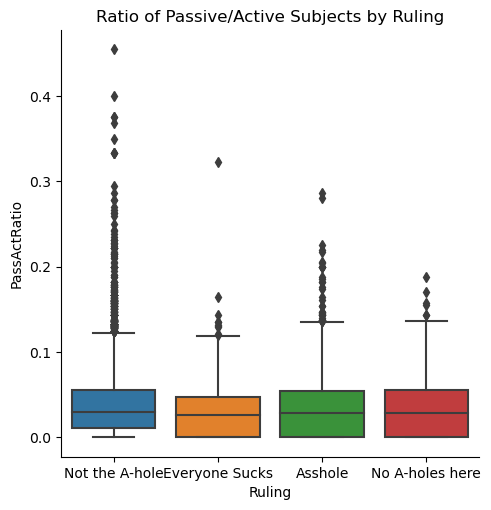

In [35]:
sns.catplot(x="Ruling", y="PassActRatio", data=analysis_df, kind="box")
plt.title("Ratio of Passive/Active Subjects by Ruling")
plt.savefig('../figures/passact.png')
plt.show()

Overall, it seems like writers are using passive voice fairly regularly across rulings. It also may be coincidental, but the order in the decreases in the ratios between passive and active voice seem to be the same as the order in the decreases  in sample size. If the number of posts per ruling were more even and more abundant, it's possible that these values would be closer. (This feels especially true given the large amount of outliers in the Not the A-hole ruling; if there were more samples for the other rulings, it would be more or less significant that there's that much variance.)

Now I'll transition to considering what the actual subjects are that are being counted.

### Breakdown of NTA Subjects

In [36]:
nta_pass = count_subjects_per_ruling("Not the A-hole", "PassiveSubjects", 30)
nta_act = count_subjects_per_ruling("Not the A-hole", "ActiveSubjects", 30)
print("Not the A-hole Total:", nta.keys())
print()
print("Not the A-hole Passive:", nta_pass)
print()
print("Not the A-hole Active:", nta_act)

Not the A-hole Total: dict_keys(['i', 'she', 'he', 'it', 'we', 'they', 'that', 'you', 'me', 'this', 'who', 'mom', 'which', 'her', 'dad', 'sister', 'parents', 'him', 'one', 'husband', 'friend', 'brother', 'what', 'mother', 'family', 'people', 'everyone', 'them', 'wife', 'things'])

Not the A-hole Passive: {'i': 3204, 'she': 1446, 'he': 1220, 'it': 1213, 'we': 574, 'they': 494, 'that': 405, 'who': 121, 'which': 98, 'this': 96, 'you': 86, 'what': 78, 'sister': 75, 'me': 69, 'mom': 69, 'everything': 62, 'parents': 58, 'brother': 58, 'all': 55, 'dad': 53, 'husband': 50, 'car': 50, 'things': 49, 'one': 48, 'mother': 46, 'son': 45, 'friend': 42, 'baby': 42, 'wife': 39, 'her': 38}

Not the A-hole Active: {'i': 132909, 'she': 38915, 'he': 31056, 'it': 21335, 'we': 21307, 'they': 14676, 'that': 6725, 'you': 5184, 'me': 5134, 'this': 4640, 'who': 3544, 'mom': 3224, 'which': 2391, 'her': 2358, 'dad': 1932, 'sister': 1799, 'parents': 1719, 'him': 1700, 'one': 1401, 'husband': 1392, 'friend': 1383, 

The order of subjects between passive and active sentences for Not the A-hole rulings is fairly consistent. The main deviations I see are that the words "everything", "all", "car", "son", "baby" are unique to the passive subjects list, and "him", "family", "people", "everyone", "them" are unique to the active subjects list.

In my mind it makes sense that a word like "everything" or "all" is used proportionally more in the passive than other nouns. They are likely being used to describe an overall change in circumstance, in which any variety of things may have acted on the situation to get to that total change they are describing. Below I'll try to pick out some examples of "everything" being used in the passive voice.

### Example, "Everything" as a Reflection on Circumstance

In [37]:
def find_token(ruling, subj, match):
    idxs = []
    for index, row in analysis_df.iterrows():
        if row["Ruling"] != ruling:
            continue
        for tok in row[subj]:
            if str(tok) == match:
                idxs.append(index)
                break
    return idxs

In [38]:
everything_idxs = find_token("Not the A-hole", "PassiveSubjects", "everything")
print(everything_idxs)
print(len(everything_idxs))

[269, 302, 320, 549, 647, 679, 968, 1021, 1042, 1112, 1320, 1476, 1510, 1617, 1779, 1922, 2050, 2349, 2591, 2825, 2853, 3363, 3368, 3490, 3728, 3953, 4123, 4195, 4373, 4517, 4742, 4888, 5232, 5373, 5384, 5411, 5522, 5536, 5683, 5746, 5890, 5952, 5975, 6080, 6601, 6603, 6677, 6699, 6791, 7041, 7478, 7499, 7509, 7538, 7883, 8152, 8240, 8640, 9108, 9311]
60


In [39]:
print(analysis_df["Title"].values[968])
print(analysis_df["Text"].values[968])
print("-------------------------------------------------------------------------------")
print(analysis_df["Title"].values[1922])
print(analysis_df["Text"].values[1922])

AITA for telling a coworker to chill out?
We had a major IT blackout at work today which affected our entire office. We were provided with a temporary solution but our browser settings saved passwords etc were not available. 

A coworker who I would say I'm friends with started freaking out about how they didn't know any of their passwords or usernames. Which, fair, I don't know some of my stuff either. But they were taking this inconvenience to the extreme. Raising their voice and trying to make their problem our problem.

I tried to placate them that everything could be fixed and to chill out for a bit, and they absolutely lost it and started slamming things on their desk and accusing me of embarrassing them.

I do feel bad about what happened but I'm kind of annoyed that I've been framed as the bad actor here. AITA?
-------------------------------------------------------------------------------
AITA for telling my mom she violated my privacy for going through my suitcase?
I (30) cam

Here, "everything" is being used to describe the various tasks or items that need to be resolved by people in the story. So it makes sense that "everything" shows up in the top passive subjects and "everyone" shows up in the top active subjects, because they are being used to describe the circumstances that need to be resolved versus the people who are doing the resolving. To me, this shows that the writers are considering accountability in the events happening in their posts and acknowledging that the events don't just create themselves.

It is important to note, also, that by saying "everything" is used proportionally more as a passive subject than other nouns, that does not mean that "everything" is being used _mostly_ as a passive subject:

In [40]:
everything_idxs = find_token("Not the A-hole", "PassiveSubjects", "everything")
print('Passive "Everything":', len(everything_idxs))
everything_idxs = find_token("Not the A-hole", "ActiveSubjects", "everything")
print('Active "Everything":', len(everything_idxs))

Passive "Everything": 60
Active "Everything": 438


### Breakdown of YTA Subjects

In [41]:
yta_pass = count_subjects_per_ruling("Asshole", "PassiveSubjects", 30)
yta_act = count_subjects_per_ruling("Asshole", "ActiveSubjects", 30)
print("Asshole Total:", yta.keys())
print()
print("Asshole Passive:", yta_pass)
print()
print("Asshole Active:", yta_act)

Asshole Total: dict_keys(['i', 'she', 'he', 'it', 'we', 'they', 'that', 'this', 'you', 'me', 'who', 'her', 'mom', 'which', 'parents', 'wife', 'him', 'friend', 'one', 'sister', 'dad', 'what', 'husband', 'people', 'brother', 'everyone', 'son', 'daughter', 'family', 'them'])

Asshole Passive: {'i': 543, 'she': 305, 'he': 219, 'it': 214, 'we': 96, 'they': 79, 'that': 78, 'this': 40, 'who': 29, 'wife': 19, 'brother': 17, 'which': 15, 'you': 14, 'what': 14, 'one': 12, 'husband': 11, 'son': 11, 'nothing': 9, 'people': 8, 'me': 8, 'mom': 8, 'family': 7, 'sister': 6, 'daughter': 6, 'kids': 6, 'money': 6, 'parents': 6, 'dad': 6, 'car': 6, 'her': 6}

Asshole Active: {'i': 24154, 'she': 8378, 'he': 5331, 'it': 4062, 'we': 4024, 'they': 2398, 'that': 1292, 'this': 945, 'you': 922, 'me': 914, 'who': 681, 'her': 491, 'mom': 487, 'which': 451, 'him': 329, 'parents': 328, 'friend': 324, 'wife': 315, 'sister': 279, 'dad': 277, 'one': 274, 'what': 266, 'husband': 260, 'people': 256, 'brother': 245, 'ever

Before analysis, it is important to again note the significantly smaller sample size being used to conser Asshole posts. But, there is a bit more interesting variance in the Asshole ruling than the Not the A-hole Ruling. The words "nothing", "kids", "money", and "car" are all unique to the passive subjects list, and the words "him", "friend", "everyone", and "them" are all unique to the active subjects list.

"him", "everyone", and "them" were also unique to the Not the A-hole active subjects list. "everyone" was previously explored when talking about the Not the A-hole subjects. "him" and "them" make sense because it seems grammatically infeasible to use those as passive subjects. Let's get an example of an active subject:

### Example, Syntactic Feasibility of "Them" as a Subject?

In [42]:
print(analysis_df["Title"].values[9290])
print(analysis_df["Text"].values[9290])

WIBTA For leaving a "subletted" room 1 month early, leaving the person who's on the lease to pay rent?
I am currently subletting a room in an apartment with some friends.

I said I would stay for 4 months, but I want to leave after 3 (at the end of this month). When I was talking w the my friends to sublet the room, I was told I could stay however long I wanted. I also offered to sign a contract for the person subletting to protect himself in case anything like this were to happen, but they said no. I’m under no contract and only verbally said how long I was gonna say.

I now need to leave at the end of this month (in 2 weeks) to be with my family, and if I do this I most likely won't be able to find someone to fill the room.

Why I could be the asshole: Because I said I would stay a different length of time than I am, and by leaving early the person on the lease would need to pay rent for a month he isn't living there.

I don’t even know the kid whose room I’m renting out and never ev

_"I...always made **them** sign contracts to protect myself_

This is really one of the only ways you can use the object case pronoun as a subject of another verb. There's not really any means to add an auxiliary in there because you are already imposing outside volition using the main clause; you can't say \*"I always made them were made to sign contracts." So "them" and "him" being exclusive to active subjects says something about grammar and not sentiment.

Now, "kid", "money", and "car" being used proportionally more in passive voice than active voice may be a happenstance caused by the specific posts pulled into this data set. It also makes sense for "money" and "car" to be more passive as they do not have animacy and therefore can't do anything themselves.

### Example, "Kid" as Unempowered in Narrative

In [43]:
kid_idxs = find_token("Asshole", "PassiveSubjects", "kid")
print(kid_idxs)
print(len(kid_idxs))

[4802, 9234]
2


There's only two posts that actually use "kid" as a passive subject, so is mostly just another case of needing a larger sample size. Let's look at them anyway.

In [44]:
print(analysis_df["Title"].values[4802])
print(analysis_df["Text"].values[4802])
print(analysis_df["PassiveSubjects"].values[4802])

AITA for calling the police on my kid?
I'm  still not sure, but I don't know what else I could have done. My kid was expected home at 7pm. 

We try to extend as much trust and space as possible, as this is a person practicing to be an independent adult. They take all their classes through the local college for credit for both high school and college. They choose to have a job. Both of these are entirely their choice.

Due to recently, Thursday, choosing not to come home at night with no discussion (my kid is 16) my teen is required to have location turned on for their phone. Instead of coming home for dinner at 7 they went to a hotel in a bad part of town. When I asked why, they lied & said they were buying a charger.

I provided a deadline (20 minutes) for them to begin their trip home. They did not. Their father and I went to the hotel,  found their car,  but couldn't get them to answer their phone so we could hear their voice and know they weren't in distress, under coercion,  and s

The main focus of this post is about justifying their rules to ensure the safety of their kid. In this instance, words like "kid" and "teen" are being used passively so that the writer can emphasizes the rules that they should be following. The writer provides context for why their kid's behavior is so worrying and therefore why their own actions should be justified. However, they are still labelled an Asshole by the community. This is likely due to readers perceiving their actions as too strict and too imposing on the agency of the kid.

### Gendering of Active Versus Passive Subjects

Lastly, it is interesting to note how the distribution of gendered terms vary between active and passive voice. Below is a listing of all the overtly gendered terms in each set:

Asshole Passive: 'she', 'he', 'wife', 'brother', 'husband', 'son', 'mom', 'sister', 'daughter', 'dad', 'her'
FMFMMMFFFMF

Asshole Active: 'she', 'he', 'her', 'mom', 'him', 'wife', 'sister', 'dad', 'husband', 'brother', 'son', 'daughter'
FMFFMFFMMMMF

Not the A-hole Passive: 'she', 'he', 'sister', 'mom', 'brother', 'dad', 'husband', 'mother', 'son', 'wife', 'her'
FMFFMMMFMFF

Not the A-hole Active: 'she', 'he', 'mom', 'her', 'dad', 'sister', 'him', 'husband', 'brother', 'mother', 'wife'
FMFFMFMFMFF

Under Not the A-hole, while the actual terms vary, the overall distribution of genders marked by the terms are almost exactly the same between passive and active voice. But, for Assholes, there is a distinct shift where masculine terms are represented higher in the passive set and feminine terms are represented higher in the active set.

## Conclusions